In [41]:
# ================== 1. Import ==================
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, models, transforms
from torch.utils.data import DataLoader
from torch.optim.lr_scheduler import CosineAnnealingLR
import time, os

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(">>> Đang sử dụng:", device)
if device.type == "cuda":
    print(">>> GPU:", torch.cuda.get_device_name(0))

# ================== 2. Data ==================
train_transform = transforms.Compose([
    transforms.Resize((256,256)),
    transforms.RandomResizedCrop(224, scale=(0.7, 1.0)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])
test_transform = transforms.Compose([
    transforms.Resize((256,256)),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])

# 👉 dataset bây giờ chỉ có 2 class: "pallet" và "nothing"
train_dir = "dataset_step1/images/train"
val_dir   = "dataset_step1/images/val"

train_dataset = datasets.ImageFolder(train_dir, transform=train_transform)
val_dataset   = datasets.ImageFolder(val_dir,   transform=test_transform)
class_names = train_dataset.classes
print("Classes:", class_names)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=4)
val_loader   = DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=4)

# ================== 3. Model ==================
modelA = models.efficientnet_b0(pretrained=True)
num_ftrs = modelA.classifier[1].in_features
modelA.classifier[1] = nn.Linear(num_ftrs, len(class_names))
modelA = modelA.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(modelA.parameters(), lr=1e-4, weight_decay=1e-4)
scheduler = CosineAnnealingLR(optimizer, T_max=10)

# ================== 4. Training ==================
best_acc, patience, trigger = 0.0, 5, 0
for epoch in range(30):
    start = time.time()
    # Train
    modelA.train()
    train_loss, train_correct, train_total = 0, 0, 0
    for x, y in train_loader:
        x, y = x.to(device), y.to(device)
        optimizer.zero_grad()
        out = modelA(x)
        loss = criterion(out, y)
        loss.backward()
        optimizer.step()
        train_loss += loss.item() * x.size(0)
        train_correct += (out.argmax(1) == y).sum().item()
        train_total += y.size(0)
    train_acc = train_correct / train_total
    train_loss = train_loss / train_total
    # Val
    modelA.eval()
    val_loss, val_correct, val_total = 0, 0, 0
    with torch.no_grad():
        for x, y in val_loader:
            x, y = x.to(device), y.to(device)
            out = modelA(x)
            loss = criterion(out, y)
            val_loss += loss.item() * x.size(0)
            val_correct += (out.argmax(1) == y).sum().item()
            val_total += y.size(0)
    val_acc = val_correct / val_total
    val_loss = val_loss / val_total
    scheduler.step()

    print(f"Epoch {epoch+1:02d} | Train Acc: {train_acc:.4f} | Train loss: {train_loss: .4f} | Val Acc: {val_acc:.4f} | Time: {time.time()-start:.1f}s")

    if val_acc > best_acc:
        best_acc = val_acc
        torch.save(modelA.state_dict(), "pallet_detector.pth")
        print("✅ Saved new best model")
        trigger = 0
    else:
        trigger += 1
        if trigger >= patience:
            print("⏹ Early stopping")
            break

print("Best Val Acc (Detector):", best_acc)


>>> Đang sử dụng: cuda:0
>>> GPU: NVIDIA GeForce RTX 3060 Laptop GPU
Classes: ['nothing', 'pallet']


d:\LAB\2025_Pallet_Demo\venv\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=EfficientNet_B0_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_B0_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 01 | Train Acc: 0.6535 | Train loss:  0.6559 | Val Acc: 0.5000 | Time: 12.1s
✅ Saved new best model
Epoch 02 | Train Acc: 0.8218 | Train loss:  0.5633 | Val Acc: 0.7500 | Time: 10.4s
✅ Saved new best model
Epoch 03 | Train Acc: 0.9505 | Train loss:  0.4679 | Val Acc: 0.8125 | Time: 10.4s
✅ Saved new best model
Epoch 04 | Train Acc: 0.9307 | Train loss:  0.3934 | Val Acc: 0.8125 | Time: 10.9s
Epoch 05 | Train Acc: 0.9802 | Train loss:  0.3359 | Val Acc: 0.8750 | Time: 10.4s
✅ Saved new best model
Epoch 06 | Train Acc: 0.9901 | Train loss:  0.2941 | Val Acc: 0.8750 | Time: 10.1s
Epoch 07 | Train Acc: 1.0000 | Train loss:  0.2657 | Val Acc: 0.9375 | Time: 10.3s
✅ Saved new best model
Epoch 08 | Train Acc: 0.9901 | Train loss:  0.2608 | Val Acc: 0.9375 | Time: 10.6s
Epoch 09 | Train Acc: 0.9802 | Train loss:  0.2677 | Val Acc: 0.8750 | Time: 10.7s
Epoch 10 | Train Acc: 0.9802 | Train loss:  0.2384 | Val Acc: 0.8750 | Time: 10.8s
Epoch 11 | Train Acc: 1.0000 | Train loss:  0.2428 | Va

d:\LAB\2025_Pallet_Demo\venv\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
d:\LAB\2025_Pallet_Demo\venv\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


<Figure size 600x600 with 0 Axes>

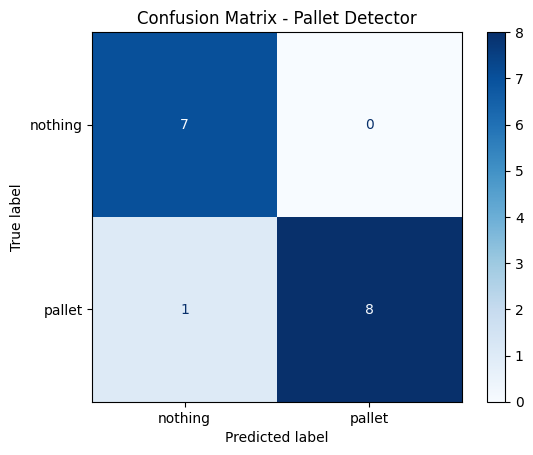

In [43]:
# ================== 5. Confusion Matrix ==================
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Load lại best model (phòng khi early stopping)
best_model = models.efficientnet_b0(pretrained=False)
num_ftrs = best_model.classifier[1].in_features
best_model.classifier[1] = nn.Linear(num_ftrs, len(class_names))
best_model.load_state_dict(torch.load("pallet_detector.pth", map_location=device))
best_model = best_model.to(device)
best_model.eval()

all_preds = []
all_labels = []

with torch.no_grad():
    for x, y in val_loader:
        x, y = x.to(device), y.to(device)
        outputs = best_model(x)
        _, preds = torch.max(outputs, 1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(y.cpu().numpy())

# Tạo confusion matrix
cm = confusion_matrix(all_labels, all_preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)

# Vẽ ma trận
plt.figure(figsize=(6,6))
disp.plot(cmap=plt.cm.Blues, values_format='d')
plt.title("Confusion Matrix - Pallet Detector")
plt.show()


In [44]:
# ================== 1. Import ==================
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, models, transforms
from torch.utils.data import DataLoader
from torch.optim.lr_scheduler import CosineAnnealingLR
import time, os

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(">>> Đang sử dụng:", device)
if device.type == "cuda":
    print(">>> GPU:", torch.cuda.get_device_name(0))

# ================== 2. Data ==================
train_transform = transforms.Compose([
    transforms.Resize((256,256)),
    transforms.RandomResizedCrop(224, scale=(0.7, 1.0)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])
test_transform = transforms.Compose([
    transforms.Resize((256,256)),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])

# 👉 dataset bây giờ chỉ có 2 class: "empty_pallet", "loaded_pallet"
train_dir = "dataset_step2/images/train"
val_dir   = "dataset_step2/images/val"

train_dataset = datasets.ImageFolder(train_dir, transform=train_transform)
val_dataset   = datasets.ImageFolder(val_dir,   transform=test_transform)
class_names = train_dataset.classes
print("Classes:", class_names)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=4)
val_loader   = DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=4)

# ================== 3. Model ==================
modelB = models.efficientnet_b0(pretrained=True)
num_ftrs = modelB.classifier[1].in_features
modelB.classifier[1] = nn.Linear(num_ftrs, len(class_names))
modelB = modelB.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(modelB.parameters(), lr=1e-4, weight_decay=1e-4)
scheduler = CosineAnnealingLR(optimizer, T_max=10)

# ================== 4. Training ==================
best_acc, patience, trigger = 0.0, 5, 0
for epoch in range(30):
    start = time.time()
    # Train
    modelB.train()
    train_loss, train_correct, train_total = 0, 0, 0
    for x, y in train_loader:
        x, y = x.to(device), y.to(device)
        optimizer.zero_grad()
        out = modelB(x)
        loss = criterion(out, y)
        loss.backward()
        optimizer.step()
        train_loss += loss.item() * x.size(0)
        train_correct += (out.argmax(1) == y).sum().item()
        train_total += y.size(0)
    train_acc = train_correct / train_total

    # Val
    modelB.eval()
    val_loss, val_correct, val_total = 0, 0, 0
    with torch.no_grad():
        for x, y in val_loader:
            x, y = x.to(device), y.to(device)
            out = modelB(x)
            loss = criterion(out, y)
            val_loss += loss.item() * x.size(0)
            val_correct += (out.argmax(1) == y).sum().item()
            val_total += y.size(0)
    val_acc = val_correct / val_total
    scheduler.step()

    print(f"Epoch {epoch+1:02d} | Train Acc: {train_acc:.4f} | Val Acc: {val_acc:.4f} | Time: {time.time()-start:.1f}s")

    if val_acc > best_acc:
        best_acc = val_acc
        torch.save(modelB.state_dict(), "pallet_classifier.pth")
        print("✅ Saved new best model")
        trigger = 0
    else:
        trigger += 1
        if trigger >= patience:
            print("⏹ Early stopping")
            break

print("Best Val Acc (Classifier):", best_acc)


>>> Đang sử dụng: cuda:0
>>> GPU: NVIDIA GeForce RTX 3060 Laptop GPU
Classes: ['empty_pallet', 'loaded_pallet']


d:\LAB\2025_Pallet_Demo\venv\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
d:\LAB\2025_Pallet_Demo\venv\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=EfficientNet_B0_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_B0_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 01 | Train Acc: 0.5616 | Val Acc: 0.7143 | Time: 10.4s
✅ Saved new best model
Epoch 02 | Train Acc: 0.9178 | Val Acc: 0.7143 | Time: 10.2s
Epoch 03 | Train Acc: 0.9863 | Val Acc: 0.8571 | Time: 10.2s
✅ Saved new best model
Epoch 04 | Train Acc: 1.0000 | Val Acc: 0.8571 | Time: 10.3s
Epoch 05 | Train Acc: 1.0000 | Val Acc: 0.8571 | Time: 11.1s
Epoch 06 | Train Acc: 1.0000 | Val Acc: 0.8571 | Time: 10.4s
Epoch 07 | Train Acc: 1.0000 | Val Acc: 0.8571 | Time: 9.8s
Epoch 08 | Train Acc: 1.0000 | Val Acc: 0.8571 | Time: 10.2s
⏹ Early stopping
Best Val Acc (Classifier): 0.8571428571428571


In [45]:
import torch
import torch.nn as nn
from torchvision import models, transforms
from PIL import Image

# ---- Step 1: Load models ----
def load_model_efficientnet(num_classes, weight_path):
    model = models.efficientnet_b0(pretrained=False)
    num_ftrs = model.classifier[1].in_features
    model.classifier[1] = nn.Linear(num_ftrs, num_classes)
    state_dict = torch.load(weight_path, map_location="cpu")
    model.load_state_dict(state_dict)
    model.eval()
    return model

# model1: Có pallet hay không
model1 = load_model_efficientnet(2, "pallet_detector.pth")

# model2: Empty pallet vs Loaded pallet
model2 = load_model_efficientnet(2, "pallet_classifier.pth")

# ---- Step 2: Preprocessing ----
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

# ---- Step 3: Inference Pipeline ----
def infer_pipeline(image_path):
    img = Image.open(image_path).convert("RGB")
    x = transform(img).unsqueeze(0)  # (1, C, H, W)

    with torch.no_grad():
        # Step 1: Pallet vs Nothing
        out1 = model1(x)
        prob1 = torch.softmax(out1, dim=1)
        pred1 = torch.argmax(prob1, dim=1).item()

    if pred1 == 0:  
        return {"label": "No Pallet", "confidence": prob1[0][0].item()}
    else:
        with torch.no_grad():
            # Step 2: Empty vs Loaded
            out2 = model2(x)
            prob2 = torch.softmax(out2, dim=1)
            pred2 = torch.argmax(prob2, dim=1).item()

        if pred2 == 0:
            return {"label": "Empty Pallet", "confidence": prob2[0][0].item()}
        else:
            return {"label": "Loaded Pallet", "confidence": prob2[0][1].item()}

# ---- Test thử ----
for i in range (1, 10):
    result = infer_pipeline(f"D:\LAB\{i}.jpg")
    print("Result:", result)
# result = infer_pipeline(r"D:\LAB\nothing.jpg")
# print("Result:", result)

<string>:57: SyntaxWarning: invalid escape sequence '\{'
<>:57: SyntaxWarning: invalid escape sequence '\{'
<>:57: SyntaxWarning: invalid escape sequence '\L'
<string>:57: SyntaxWarning: invalid escape sequence '\{'
<>:57: SyntaxWarning: invalid escape sequence '\{'
<>:57: SyntaxWarning: invalid escape sequence '\L'
C:\Users\ducho\AppData\Local\Temp\ipykernel_15884\3009217237.py:57: SyntaxWarning: invalid escape sequence '\{'
  result = infer_pipeline(f"D:\LAB\{i}.jpg")
C:\Users\ducho\AppData\Local\Temp\ipykernel_15884\3009217237.py:57: SyntaxWarning: invalid escape sequence '\L'
  result = infer_pipeline(f"D:\LAB\{i}.jpg")
d:\LAB\2025_Pallet_Demo\venv\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


Result: {'label': 'Loaded Pallet', 'confidence': 0.7447136640548706}
Result: {'label': 'Loaded Pallet', 'confidence': 0.7024616003036499}
Result: {'label': 'Loaded Pallet', 'confidence': 0.6894635558128357}
Result: {'label': 'Loaded Pallet', 'confidence': 0.8486283421516418}
Result: {'label': 'Loaded Pallet', 'confidence': 0.7368658781051636}
Result: {'label': 'Loaded Pallet', 'confidence': 0.7368658781051636}
Result: {'label': 'Loaded Pallet', 'confidence': 0.7700209021568298}
Result: {'label': 'Loaded Pallet', 'confidence': 0.7031177878379822}
Result: {'label': 'No Pallet', 'confidence': 0.5749446749687195}
